In [2]:
import sys
import os
project_path = os.path.abspath('../..')
if project_path not in sys.path:
    sys.path.append(project_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Ruta corregida al archivo procesado
project_root = os.path.abspath('../../..')
processed_path = os.path.join(project_root, 'data', 'processed', 'walmart_sales_processed.csv')

df = pd.read_csv(processed_path)
df['Date'] = pd.to_datetime(df['Date'])
df['revenue'] = df['quantity_sold'] * df['unit_price']

print("Datos cargados correctamente")
df.head()

Datos cargados correctamente


,transaction_id,customer_id,product_id,product_name,category,quantity_sold,unit_price,transaction_date,store_id,store_location,...,weekday,stockout_indicator,forecasted_demand,actual_demand,Date,Year,Month,Week,Is_Holiday_Week,revenue
0,1,2824,843,Fridge,Electronics,3,188.46,3/31/2024 21:46,3,"Miami, FL",...,Friday,True,172,179,2024-03-31 21:46:00,2024,3,13,0,565.38
1,2,1409,135,TV,Electronics,4,1912.04,7/28/2024 12:45,5,"Dallas, TX",...,Monday,True,109,484,2024-07-28 12:45:00,2024,7,30,0,7648.16
2,3,5506,391,Fridge,Electronics,4,1377.75,6/10/2024 4:55,1,"Los Angeles, CA",...,Tuesday,True,289,416,2024-06-10 04:55:00,2024,6,24,0,5511.00
3,4,5012,710,Smartphone,Electronics,5,182.31,8/15/2024 1:03,5,"Miami, FL",...,Sunday,False,174,446,2024-08-15 01:03:00,2024,8,33,0,911.55
4,5,4657,116,Laptop,Electronics,3,499.28,9/13/2024 0:45,6,"Chicago, IL",...,Thursday,True,287,469,2024-09-13 00:45:00,2024,9,37,0,1497.84



Elasticidad Electronics: -0.002
Interpretación: 10% aumento de precio → -0.0% cambio en demanda


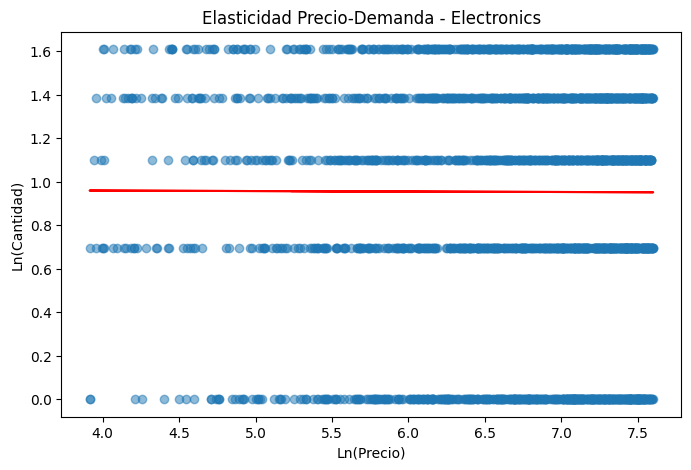


Elasticidad Appliances: -0.021
Interpretación: 10% aumento de precio → -0.2% cambio en demanda


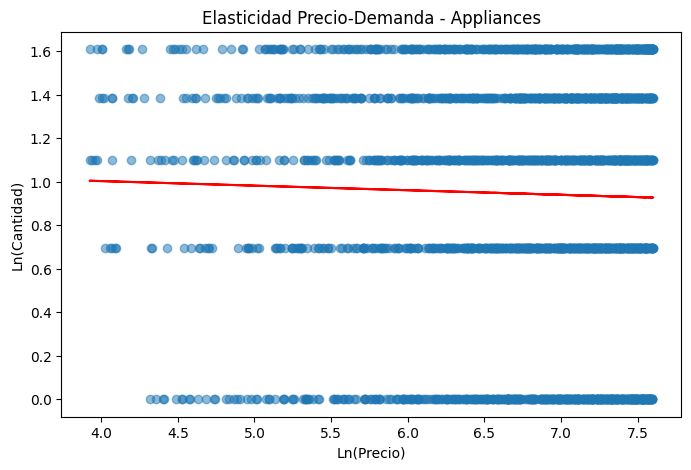


Resumen de elasticidades: {'Electronics': np.float64(-0.0021549359441238604), 'Appliances': np.float64(-0.02103262081817513)}


In [3]:
# Filtrar categorías principales
categories = ['Electronics', 'Appliances']  # Puedes agregar más si hay

elasticities = {}

for cat in categories:
    cat_df = df[df['category'] == cat].copy()
    if len(cat_df) < 10:
        continue
    
    # Log-log model: ln(quantity) = β0 + β1*ln(price) + ε
    cat_df = cat_df[(cat_df['quantity_sold'] > 0) & (cat_df['unit_price'] > 0)]
    cat_df['ln_quantity'] = np.log(cat_df['quantity_sold'])
    cat_df['ln_price'] = np.log(cat_df['unit_price'])
    
    X = sm.add_constant(cat_df['ln_price'])
    y = cat_df['ln_quantity']
    
    model = sm.OLS(y, X).fit()
    elasticity = model.params['ln_price']
    elasticities[cat] = elasticity
    
    print(f"\nElasticidad {cat}: {elasticity:.3f}")
    print(f"Interpretación: 10% aumento de precio → {elasticity*10:.1f}% cambio en demanda")
    
    # Gráfico
    plt.figure(figsize=(8,5))
    plt.scatter(cat_df['ln_price'], cat_df['ln_quantity'], alpha=0.5)
    plt.plot(cat_df['ln_price'], model.predict(X), color='red')
    plt.title(f'Elasticidad Precio-Demanda - {cat}')
    plt.xlabel('Ln(Precio)')
    plt.ylabel('Ln(Cantidad)')
    plt.show()

print("\nResumen de elasticidades:", elasticities)

In [4]:
import numpy as np
import pandas as pd

class QLearningPricer:
    def __init__(self, base_price, elasticity=-1.2, learning_rate=0.1, discount=0.95, episodes=1000):
        self.base_price = base_price
        self.elasticity = elasticity
        self.lr = learning_rate
        self.gamma = discount
        
        # 5 estados de demanda, 11 acciones (-50% a +50%)
        self.q_table = np.zeros((5, 11))
        
    def get_state(self, demand_ratio):
        return min(int(demand_ratio * 5), 4)  # 0-4
    
    def demand_function(self, price_change):
        # Demanda = base * (price_change)^elasticity
        price_ratio = 1 + price_change
        return max(price_ratio ** self.elasticity, 0.1)
    
    def train(self, base_demand=1000):
        for _ in range(1000):
            state = np.random.randint(0, 5)
            action = np.random.randint(0, 11) if np.random.random() < 0.1 else np.argmax(self.q_table[state])
            
            price_change = (action - 5) * 0.1  # -0.5 a +0.5
            demand = base_demand * self.demand_function(price_change)
            revenue = (self.base_price * (1 + price_change)) * demand
            
            next_state = self.get_state(demand / base_demand)
            reward = revenue
            
            self.q_table[state, action] += self.lr * (reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state, action])
    
    def get_optimal_price(self, current_demand_ratio):
        state = self.get_state(current_demand_ratio)
        action = np.argmax(self.q_table[state])
        price_change = (action - 5) * 0.1
        return self.base_price * (1 + price_change)

# Ejemplo de uso
pricer = QLearningPricer(base_price=1000, elasticity=-1.3)
pricer.train()
optimal = pricer.get_optimal_price(1.0)
print(f"Precio óptimo sugerido: ${optimal:.2f}")

Precio óptimo sugerido: $500.00
